 <style>
.footer {
  position: fixed;
  left: 0;
  bottom: 0;
  width: 100%;
  background-color: white;
  color: grey;
  text-align: left;
  font-size: 8px;
}
</style>
<style>
.header {
  position: fixed;
  left: 0;
  top: 0;
  width: 100%;
  background-color: white;
  color: grey;
  text-align: center;
  font-size: 8px;
}
</style>


<img align="left" width="30%" style="padding-right:10px;" src="../Images/Ccom.png">

___
# Computational Problem Set - Being a VGNSS Receiver

## Step 7: Using the Non-Linear Parametric Method of the Least Squares

## Semme J. Dijkstra, David E. Wells



Implement an iterative non-linear parametric least squares GNSS position fix that converges to a solution. In other words repeatedly estimate a corrector $\hat{\delta}$ to position and time estimate $\hat x$ so that:

$$ A^TC_{obs}^{-1}A\hat\delta+A^TC_{obs}^{-1}\vec w=\vec0$$



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jupyter-semmed/ESCI_OE_771_871
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jupyter-semmed/ESCI_OE_771_871
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jupyter-semmed/ESCI_OE_771_871
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jupyter-semmed/ESCI_OE_771_871
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jupyter-semmed/ESCI_OE_771_871
Reading SP3 file: ../mydata/igs13381.sp3
Reading SP3 file: ../mydata/igl13381.sp3
Reading rinex nav file: ../mydata/brdc2410.05n
a:      6378137.000
b:      6356752.314
f:  0.0033528106718
e2: 0.0066943800043
N:     6383561.9968
xyz = 
	      36572.327
	   -5514234.862
	    3194349.181
n_gps: 29

Dxyz_gps = 
	  -14810463.942    -9214095.559    13455967.472
	   13541201.761

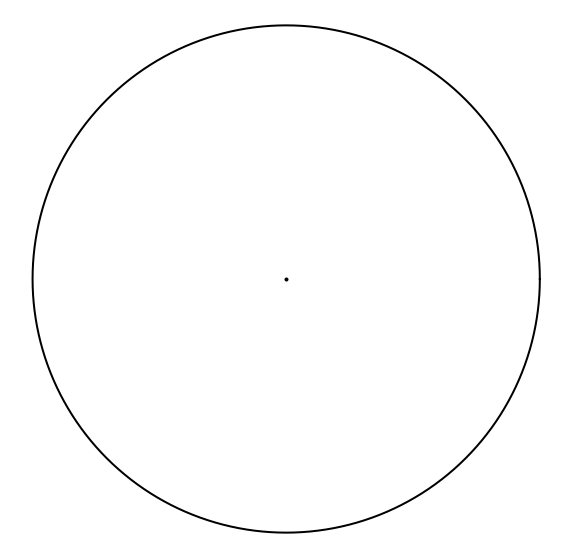

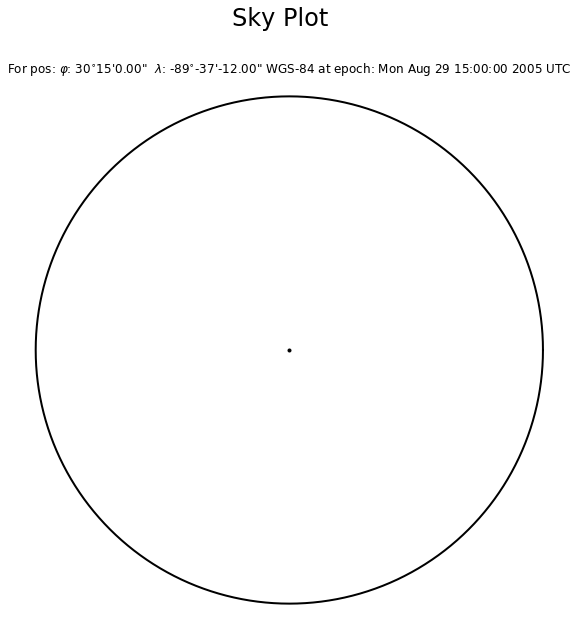

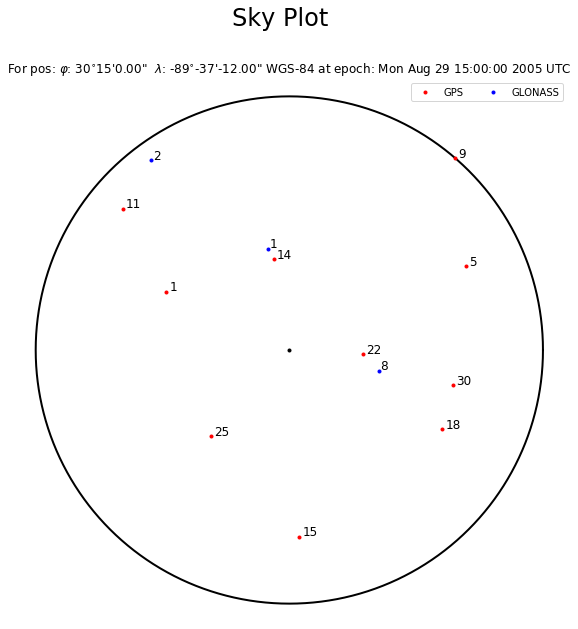

GPS PRN 2 is not visible; re-assigning bv to GPS PRN 1
Tropo delay model: 2.31/sin(sqrt(elev^2+2.50^2))
rnd_gps = 
	          1.728
	         -0.805
	          0.683
	          2.402
	         -1.062
	          0.499
	          1.848
	         -2.193
	         -1.838
	         -0.146
	         -1.439
	          1.003
	          2.381
	         -1.607
	          0.900
	          1.803
	          2.760
	          1.692
	          1.351
	          1.315
	         -2.802
	          0.527
	         -2.984
	          0.228
	          0.942
	         -0.520
	          2.122
	          2.472
	          1.306

n_gps_vis = 10

error_gps = 
	  PRN    elev  Tr. Delay Rnd Noise   Clock Bias  Blunder   Tot. Uncertainty
	    1   0.728      3.468     1.728     1000.000 2000.000           3005.196
	    5   0.359      6.522    -1.062     1000.000    0.000           1005.460
	    9   0.002     52.891    -1.838     1000.000    0.000           1051.053
	   11   0.219     10.436    -1.439     1000.000    0.

In [319]:
%load_ext autoreload
%autoreload 2


import sys
import os
import numpy as np

from copy import copy
from numpy import cos,pi,sin,pi,arccos, tan, arctan, arctan2, sqrt
from numpy.linalg import inv
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pathlib import Path
from IPython.display import HTML
vgnss_path=Path('../') # Get the path to the folder containing the mycode folder

print(vgnss_path.resolve())
sys.path.append(str(vgnss_path.resolve())) # add the folder to the list of paths 
from mycode.gnss import GNSS
from mycode.sp3 import SP3
# Start by running your previous steps - suppress the output by setting verbose to False


%run VGNSS_6.ipynb
verbose = True

from IPython.display import HTML, display

def set_background(color):    
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)

    display(HTML('<img src onerror="{}">'.format(script)))

# from mycode.lsq import LSQ
# from mycode.ephemeris import Ephemeris

___
## 7.0 Calculate the Covariance Matrix $C_l$ of the Observations $l^o$

Having an estimate $\hat x$ allows us to calculate the misclosures $\vec{w}$, which are an estimate $\hat r$ of the residuals. The more accurate the estimate $\hat x$ becomes the better we can estimate the uncertainty $C_r$ associated to it. In the lectures on the method of the least squares we have seen that $C_l = C_r$, thus as the $\hat x$ converges onto $\vec x$ so will our ability to identify the uncertainty $\hat C_l$ associated to the observations. 

For simplicity we will assume that all our GNSS observations share an equal uncertainty that we will call the variance factor which is commensurate with the misclosures for the current solution. For our solution we will use a weight matric $P=C_l^{-1}$. With the equally weighed observations that result the estimate $\hat x$ remains unaffected by $C_l$. However, our estimate of its associated uncertainty $C_x$ will be improved as $C_x = (A^TPA)^{-1}$. In the code we will keep track of the variance of the residuals by using the variable `var_fac`. Normally we do not yet have an estimate of the uncertainty of the residuals and use manufacturers specifications for the purpose. In our case we will use the a-priori uncertainty variance $\sigma_0^2$ calculated in step [5.6](./VGNSS_5.ipynb) and assigned to `var_a_priori` 

In this assignment we want to be able to look at how our solution develops through the iterations i.e., we will lists  for each variable with their value for each iteration $i$.

In the code cell below you will create a list `var_fac` that holds successive variance factor values and add `var_a_priori` as the first element. Also create the list `Cl` holding the ${C_l}_i$ matrix for each iteration. The first element will then be:

    - Cl = [var_fac[0] * np.eye(n_svs)]
    
or the product of an identity matrix with a dimension matching the number of observations and the variance factor. Note that this implies that the observations are *uncorrelated* which is not true in real life, but difficult to characterize.


In [1]:
## 7.0 Calculate the Covariance Matrix 𝐶𝑙 of the Observations 𝑙

# Start a list var_fac with as its first element var_a_priori
var_fac = [...]
Cl = [var_fac[0] * np.eye(...)]

NameError: name 'np' is not defined

In [321]:
# Output for step 7.0

if verbose:
    print('    Cl[0] = ')
    for i in range(n_svs):
        print('   ',end =" ")
        for j in range(n_svs):
            print( '%5.2f'%(Cl[0][i,j]),end =" "),
        print('')

    Cl[0] = 
    267.27  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
     0.00 267.27  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
     0.00  0.00 267.27  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
     0.00  0.00  0.00 267.27  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
     0.00  0.00  0.00  0.00 267.27  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
     0.00  0.00  0.00  0.00  0.00 267.27  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
     0.00  0.00  0.00  0.00  0.00  0.00 267.27  0.00  0.00  0.00  0.00  0.00  0.00 
     0.00  0.00  0.00  0.00  0.00  0.00  0.00 267.27  0.00  0.00  0.00  0.00  0.00 
     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 267.27  0.00  0.00  0.00  0.00 
     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 267.27  0.00  0.00  0.00 
     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 267.27  0.00  0.00 
     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00

Worked Example:
    
    Cl[-1] = 
    267.27  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
     0.00 267.27  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
     0.00  0.00 267.27  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
     0.00  0.00  0.00 267.27  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
     0.00  0.00  0.00  0.00 267.27  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
     0.00  0.00  0.00  0.00  0.00 267.27  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
     0.00  0.00  0.00  0.00  0.00  0.00 267.27  0.00  0.00  0.00  0.00  0.00  0.00 
     0.00  0.00  0.00  0.00  0.00  0.00  0.00 267.27  0.00  0.00  0.00  0.00  0.00 
     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 267.27  0.00  0.00  0.00  0.00 
     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 267.27  0.00  0.00  0.00 
     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 267.27  0.00  0.00 
     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 267.27  0.00 
     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 267.27 

## 7.1 Calculate the Weight Matrix P

Normally we weight observations by the inverse of their expected uncertainty i.e.,

$$P_i= C_{l,i}^{-1}$$

In the code cell below create the list `P` holding the weight matrices and assign the first element the inverse of the observation covariance matrix $C_l$ held by the corresponding element in list `Cl`. Use the `numpy` method `inv()` for this purpose.


In [322]:
## 7.1 Calculate the initial weight Matrix P
P = [...]


In [323]:
if verbose:
    print('    P[0] = ')
    for i in range(n_svs):
        print('   ',end =" ")
        for j in range(n_svs):
            print( '%.4f'%(P[0][i,j]),end =" "),
        print('')

    P[0] = 
    0.0037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0000 0.0037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0000 0.0000 0.0037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0037 0.0000 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0037 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0037 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0

Worked Example:
    
    P[-1] = 
    0.0037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0000 0.0037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0000 0.0000 0.0037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0037 0.0000 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0037 0.0000 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0037 0.0000 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0037 0.0000 0.0000 
    0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0037 0.0000 
    0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0037 

## 7.2 Calculate the Misclosures $\vec w$ and Design $A$ of the Current Estimate $\hat{\vec x}$

in this step we will create the lists `x_est`, `w` and `A` holding the successive estimates $\hat{ x}_i$, and the associate misclosures $w_i$ and design matrices $A_i$

The first elements are thus `x_est[0]` the initial estimate $\hat{x}_0$ given by your variable `xyzt_0` and the associated `w[0]` holding $\vec w_0$ and `A[0]` holding $A_0$

Note that we will use the function `get_design_misclosure_range` that we generated in step 6 for this purpose


In [2]:
## 7.2 Get the design matrix and misclosure vectors using the current estimate x_est[-1] and l_obs
w = []  # Empty list to hold the misclosure vectors
A = []  # Empty list to hold the design matrices
Cx = [] # Empty list to hold the covariance matrices Cx

# Add the initial estimate to the list x_est
x_est = [xyzt_0]

# Get the design A and misclosures w for x_est
result = get_design_misclosure_range(..., ..., ..., ..., False)
w.append(result[0])
A.append(result[1])


NameError: name 'xyzt_0' is not defined

In [325]:
if verbose:
    print('\n    The initial misclosure vector w =')
    for i in range(n_svs):
        print('    %15.3f'%(w[0][i]))
    print('\n    The initial design matrix A =')
    for i in range(n_svs):
        print('    %9.3f %7.3f %7.3f %7.3f'%(A[0][i,0],A[0][i,1],A[0][i,2],A[0][i,3]))
    


    The initial misclosure vector w =
          -2525.393
          -2279.746
          -2740.565
          -1041.338
          -1340.268
            338.831
          -1066.597
          -1093.507
            378.883
          -1428.515
          -1395.556
          -1485.823
          -1066.679

    The initial design matrix A =
        0.672   0.418  -0.611 299792458.000
       -0.846   0.096  -0.524 299792458.000
       -0.652  -0.383  -0.654 299792458.000
        0.746  -0.125  -0.654 299792458.000
        0.090   0.459  -0.884 299792458.000
       -0.052   0.806   0.589 299792458.000
       -0.780   0.616   0.104 299792458.000
       -0.446   0.786  -0.429 299792458.000
        0.437   0.898   0.044 299792458.000
       -0.846   0.524  -0.100 299792458.000
        0.122   0.397  -0.910 299792458.000
        0.587  -0.299  -0.752 299792458.000
       -0.529   0.786  -0.319 299792458.000


Worked Example:

     The initial misclosure vector w =
          -2525.393
          -2279.746
          -2740.565
          -1041.338
          -1340.268
            338.831
          -1066.597
          -1093.507
            378.883
          -1428.515
          -1395.556
          -1485.823
          -1066.679

    The initial design matrix A =
        0.672   0.418  -0.611 299792458.000
       -0.846   0.096  -0.524 299792458.000
       -0.652  -0.383  -0.654 299792458.000
        0.746  -0.125  -0.654 299792458.000
        0.090   0.459  -0.884 299792458.000
       -0.052   0.806   0.589 299792458.000
       -0.780   0.616   0.104 299792458.000
       -0.446   0.786  -0.429 299792458.000
        0.437   0.898   0.044 299792458.000
       -0.846   0.524  -0.100 299792458.000
        0.122   0.397  -0.910 299792458.000
        0.587  -0.299  -0.752 299792458.000
       -0.529   0.786  -0.319 299792458.000

## 7.3 Calculate Adjustment Covariance Matrix $C_\delta$

in this step we will create the list `Cd`, holding the covariance $C_{d,i}$ of the successive adjustments $\hat{\vec\delta}_i$

The next estimate of the unknown $\vec x_{i+1}$ and $\vec\delta_i$ share their covariance matrix: that is $C_{x,i+1}=C_{\delta,i}$, which is the inverse of the **Normal Equations** N:

$$ N = A^TC_l^{-1}A = A^TPA\Rightarrow$$

$$C_{\delta,i}= C_{x,i+1} = \left(A_i^TP_iA_i\right)^{-1}$$

In the code cell below calculate the covariance matrix $C_{d,0}$ of the current estimate $\hat{\vec\delta}_0$ using the current design matrix `A[0]` and misclosure vector `w[0]` and add it to the list `Cd`.

Note that the resulting variance and covariances associated to the time bias are zero i.e., the time is completely solved in the very first iteration!

In [3]:
## 7.3 Calculate Adjustment Covariance Matrix
Cd = [] # Empty list to hold the covariance matrices Cd

# Determine the covariance Cd of the *current* estimate of x
Cd.append(inv(A[0].T@...@...))


NameError: name 'inv' is not defined

In [327]:
if verbose:
    print('    Cd = ')
    for i in range(len( x_est[0])):
        print('   ',end =" ")
        for j in range(len( x_est[0])):
            print( '%15.3f'%(Cd[0][i,j]),end =" "),
        print('')
    

    Cd = 
             66.871          -1.538          26.608           0.000 
             -1.538         186.641        -110.720          -0.000 
             26.608        -110.720         190.127           0.000 
              0.000          -0.000           0.000           0.000 


 Worked Example: 
     
     Cd = 
             66.871          -1.538          26.608           0.000 
             -1.538         186.641        -110.720          -0.000 
             26.608        -110.720         190.127           0.000 
              0.000          -0.000           0.000           0.000 

## 7.4 Estimate the Adjustment Vector $\hat\delta$

in this step we will create the list `delta`, holding the adjustments $\hat\delta_{i}$ for the successive estimates $\hat{\vec x}_i$


$$\hat{\delta}_i = -\left(A_i^TP_iA_i\right)^{-1}A_i^TP_i\vec w_i$$
    
using the adjustment covariance matrix $C_{\delta,i}\Rightarrow$

$$\hat{\delta}_i = -C_{\delta,i}A_i^TP_i\vec w_i$$

For this first iteration we then use `Cd[0]`, `A[0]`, `P` and, `w[0]`, i.e., the current values.

Note that adjustment vector $\hat{\delta}_i$, is the correction to $\hat{ x}_i$, thus

$$\hat{ x}_{i+1} = \hat{ x}_i+\hat{\delta}_i$$

This means that the associated uncertainty $C_{x,i+1} = C_{\delta,i}$


In [328]:
## 7.4 Estimate the Adjustment Vector delta
# Create the list of the adjustments delta
delta = []

# Add the first adjustment to the list
delta.append(-Cd[0]@...)


In [329]:
if verbose:
    print('    delta = ')
    for i in range(len( delta[0])):
        print( '%15.3f'%(delta[0][i]))


    delta = 
       -655.377
       -805.803
      -1178.345
          0.000


Worked example:

    delta = 
       -655.377
       -805.803
      -1178.345
        -60.000

## 7.5 Estimate the Residual Vector $\hat{\vec r}$

The residual $\vec r$ is the difference between the unknown observables (i.e. what the ranges should be) and the observations $l^0$, as opposed to the misclosures $\vec w$, which are the difference between the modeled observations $l$ and the observations $l^o$ themselves. Note that since $\hat{  x}_{i+1} = \hat{ x}_i+\hat{\delta}_i$  residuals $\vec r_i$ calculated from $w_i$ and $A_i$ are associated to the ***next*** estimate $\hat{ x}_{i+1}$! Since we have not updated the initial estimate yet the adjustments are still zero i.e.

$$\hat{ r}_{i+1} = A_i\hat{\delta}_i  + \vec w_i$$


In [330]:
## 7.5 Estimate the Residual Vector r
r = [] # list of residual vectors

r.append(A[0]...)

In [331]:
if verbose:
    print('    r = ')
    for i in range(len( r[0])):
        print( '%15.3f'%(r[0][i]))


    r = 
      -1524.241
       -125.905
       -174.323
        399.650
        331.669
         88.427
       -115.254
        130.757
        376.328
       -119.898
        335.417
        316.320
         81.053


Worked example:

    r = 
      -1524.241
       -125.905
       -174.323
        399.651
        331.669
         88.427
       -115.254
        130.757
        376.328
       -119.898
        335.417
        316.320
         81.053

## 7.6 Compute the initial Factor $\sigma_i^2$ and Root Mean Square Error

Compute the variance factor $\sigma_i^2$ using the estimated residual $\hat{\vec r}$. This variance vector is a potentially better estimate of the uncertainty associated to the observations as it is based on the residuals. The variance factor is the sum of the squares of the residuals divided by the degrees of freedom i.e,:

$$ \sigma_i^2 = \dfrac{\hat r_{i-1}^TC_{l,i-1}^{-1} \hat r_{i-1}}{ (n - u)}= \dfrac{\hat r_{i-1}^TP_{i-1} \hat r_{i-1}}{ (n - u)}$$

where $n$ is the number of satellites used in the computation i.e., `n_svs`, and $u$ is the number of unknown parameters in $\vec x$ i.e., the length of `x_est[0]`.

In the code cell below calculate variance factor $\sigma_i^2$ to the list `var_fac`. Note that this is the variance factor associated to the *current* iteration that may be used as the *a-priori* **uncertainty** for the next iteration. Note that in this case it will increase the uncertainty of the estimate, despite the estimate being closer to the truth, as there is the influence of the blunder that affects the estimate. 

If we see such an increase in the uncertainty estimate after the first estimate this is an indication that non-random error is present that is unaccounted for in the a-priori variance estimate. The two most common causes for this are the presence of blunders (as we know is the case here) and/or overly optimistic estimates of the accuracy of the observations. Thus the variance factor is a valuable tool to determine whether the instrument is performing according to expectation, especially after gross errors have been eliminated.

Note that we still consider this an ***a-priori*** variance factor as it is calculated from a previous state, but used to estimate the uncertainty of observations in the current state. Once we have converged to a best estimate $\hat{\vec x}$ by minizing the residuals this becomes our best estimate of the overall precision of the observations. It is then referred to as the ***a-posteriority*** variance factor, which is an important factor in determining whether the observations were of the quality that we expected. The commonly used term **Root Mean Square Error** or **RMSE** is then the square root of the a-posteriority variance factor.

In [332]:
## 7.6 Compute the Variance Factor 𝜎[𝑖]^2
var_fac_int = r[0].T.../(n_svs...)


Worked Example:

    var_fac_int = 1269.03

## 7.7 Create the Iterative Loop in which $\hat{x}$ is Determined

We estimate the unknown position and time $\vec x$ by starting with the initial estimate $\hat{ x}_0$ and iteratively refining it by the adjustment $\hat{\delta}_i$. Theoretically we expect each iteration to produce a better estimate and thus smaller magnitude residual vector ${\hat{ r}_i}^TP\hat{r}_i$. For numeric reasons this is *not* the case; we should stop if ${\hat{\vec r}_i}^TP\hat{\vec r}_i$ starts oscillating i.e., successively increasing and decreasing. As we are minimizing the sum of the squared residuals the first time ${\hat{\vec r}_i}^TP\hat{\vec r}_i$ increases we have converged to a solution.

Note that fact that we can keep on computing until $\hat{\delta}_i$ has converged does *not* mean that we should. At some points the adjustments $\hat{\delta}_i$ contained at `delta[-1]` become insignificant and just take unneeded resources to compute. To address this we normally predefine a convergence criterion for the norm of $\hat{\delta}_i$ , a standard by which we decide that a solution is sufficiently close, regardless whether it has numerically converged. Note that this has the potential of **significantly** reducing computing time.

Both the above criteria are tested each iteration; sufficient convergence is not guaranteed either way. Therefore we should also have a mechanism to stop the iteration regardless the results. For a positioning problem such as the one presented here we normally expect to converge on a solution in three iterations or less. Thus, if we limit the maximum number of iterations `max_iter` to 10 it is highly unlikely that we preemptively interrupt the adjustment procedure.

Thus the criteria to stop the iterations are:
We want to stop iterations stop after:
    - 1) the magnitude of the residual vector `r` increases in magnitude, but this should be tested only after the 2nd estimate i.e, iteration.
    - 2) the magnitude of the adjustment vector `delta` becomes less than `conv_crit`
    - 3) the loop has iterated `max_iter` times


## 7.7.0 The Iterative Loop Initialization

The approach that we have taken so-far is that we started with an initial estimate $\hat{ x}_0$ and calculated all the associated parameters in steps 7.0 through 7.6. After step 7.6 we have all the parameter values needed to start estimating $\hat{ x}_i$ iteratively in a loop. We do not know how many iterations $i$ we need to execute beforehand so we will create a variable `done` initiated with the value `False`. In each iteration we will then test the three criteria listed in 7.7, if any of them is met we will set `done = True`.

In the code cell below complete the code for the initialization. Use 10 for the maximum of iterations `max_iter` and .1mm as the convergence criterion i.e., `conv_crit = 0.0001`. 

We also want to keep an index for the iterations, for this we will use the variable `i` with values consistent to Python indexing i.e., the first elements of our lists have index 0. 

Finally we want to guarantee that the `while` loop gets executed at least once i.e., that at least one attempt is made to improve on our initial estimate of the unknown, for this to happen set `done` to `False` 

In [333]:
##7.7.0 The Iterative Loop Initialization

# Set the converge and max iteration criteria
conv_crit = ...     # Set the appropriate convergence criterion, note that the distance units in the code are m
max_iter = ...      # The maximum number of iterations before we move on
i = 0               # We are at iteration 0
done = False

## 7.8 The Loop Body Updating the Parameter Values

The goal of our code is to achieve a best estimate $\hat{x}$ by estimating a series of successive  estimates $\hat{x}_i$ until success (sufficient convergence) or failure (lack of convergence) has been achieved. For each updated estimate $\hat{x}_i$ we will need to make sure that all the other variables are updated as well i.e., $\hat\sigma_i^2$, $C_{l,i}$, $P_{i}$, $w_{i}$, $A_{i}$, $C_{\delta,i}$, $C_{l,i}$, $\hat{ \delta}_i$ and, $\hat{ r}_i$.

At the start of the while loop all values are current for the index $i$. As soon as we update `i` using $i = i + 1$ all variables are out of date; we need to update all the parameters to the current state $i$. Note that the updates of the variables needs to occur in the correct order for them to be valid.

To do this step update the code cell found below - we will force the iterations to stop after the very first execution of the while loop by simply setting `done` to `True`.
___
The first parameter that we will update is $\hat{\vec x}_i$

$$\hat{\vec x}_i = \hat{\vec x}_{i-1}+\hat{\vec \delta}_{i-1}$$

The estimates $\hat{ x}_i$ are kept in the list `x_est` and the estimates $\hat{\vec \delta}_{i-1}$ are kept in the list `delta` i.e., the current estimates $\hat{\vec x}_{i-1}$ and $\hat{\vec \delta}_{i-1}$ are found at `x_est[-1]` and `delta[-1]` respectively. Thus the way in which to update and add the current estimate is to use the statement:

    x_est.append(x_est[-1]+delta[-1]) 
___
    
At this point we may also update the (a-priori) variance factor $\hat\sigma_i^2$ estimate using the same approach as in section 7.6. 
$$ \sigma_i^2 = \dfrac{\hat r_{i-1}^TP_{i-1} \hat r_{i-1}}{ (n - u)}$$

Currently the `r[-1]` holds $\hat r_{i-1}$ and `P[-1]` holds $P_{i-1}$, add the updated estimate $\sigma_i^2$ to the list `var_fac` using them.
___

Now that we have $ \sigma_i^2$ in `var_fac[-1]` we may append $C_{l,i}$ and $P_{i}$ to the lists `Cl` and `P` using it in a fashion similar to step 7.0 (but with appropriate indexing).
___
The design matrix $A_i$ and misclosure vector $w_i$ need to be added to the lists `A` and `w`. Determine these in the same fashion as before using the current estimate  $\hat{ x}_i$ 
___
Now that we have $A_i$ held in `A[-1]` use this and `P[-1]` to update the covariance matrix $C_{\delta,i}$
___ 
Use the  $C_{\delta,i}$ held in `Cd[-1]` together with the current $A_i$ and $P_i$ to estimate the new adjustment $\hat{\vec \delta}_{i}$ and add it to the list `delta`
___
Use the $\hat{\vec \delta}_{i}$ held in `delta[-1]`, $A_i$ and, $w_i$ to estimate $r_i$


In [334]:
## # Copy the code from steps 7.0 to 7.7.0 here 

...

# If the previous steps were not copied a sequence problem may occur - check whether this is the case
if not i == 0 or not len(x_est) == 1:
    raise RuntimeError('Make sure to copy steps 7.0 through 7.7.0 in this code cell')

# Initialization needed for step 7.11
dof = n_svs-len(x_est[-1])
bv_est = []
    
while not done:
    # All parameters are consistent with the current value of the number iterations i
    # update i to start the next iteration
    i += 1
    
    ## 7.8 Parameter values are now out of date, make them be consistent with the current iteration (i)
    # Start with the estimate i.e., Create the next estimate
    x_est.append(x_est[-1]+delta[-1])
    
    # There are now i+1 estimates for position, but only i for 
    # A, w, var_fac, Cx Cl, P, Cd, delta and r for the first estimate
    # At this point update all of them 
    
    # Update var_fac using the equations from 6.6
    var_fac.append(  r[-1].T@P[-1]@r[-1]/dof)
    
    # Update Cl and P (same way as in intial step)
    Cl.append(var_fac[-1] * np.eye(n_svs))
    P.append(inv(Cl[-1]))
    
    # Deweigh the outliers (this will make sense after step 7.11)   
    if len(bv_est):
        for sv in bv_est:
            P[-1][sv,sv]=0
        
        
    # Update A and w (same manner as before)
    result = get_design_misclosure_range( x_est[-1], eph, l_obs, c, False)
    w.append(result[0])
    A.append(result[1])
    
    # Update the adjustment covariance matrix
    Cd.append(inv(A[-1].T@P[-1]@A[-1]))
    
    # Determine the new adjustment vector
    delta.append(-Cd[-1]@A[-1].T@P[-1]@w[-1])
    
    # Estimate the residuals associated to the current delta (thus the next est of x)
    r.append(A[-1]@delta[-1]+w[-1])
    
    done = True
    
#     ## 7.9 Uncomment the code below
    
#     done = False  
#     # Check whether the solution has converged by checking the residual estimates for oscilation
#     if r[-1].T@r[-1] > ...:
#         done = True
#         if verbose:
#             print('The solution has converged, this is a rare occurence when outliers are present')
#     elif sqrt(...) < ...: 
#         done = True
#         if verbose:
#             print('The convergence criterion of %.1fmm was reached in %d steps'%(1000*conv_crit,i))
#     elif i ...:
#         if verbose:
#             print('No convergence, max iterations reached')
            
            
# #     ## 7.11 Eliminate blunders

# #     max_r = max(abs(r[-1]))
# #     idx = max_r==...
# #     rmse = np.std(abs(...))
# #     for sv in np.where(abs(r[-1][:,0])>...)[0]:
# #         bv_est.append(sv)  # Not optimal - leads to repeat identification - not a big deal though

# Create the final update
x_est.append(x_est[-1]+delta[-1])


# The difference between the true x and our estimate
error_xyz = x_est[-1][0:3]-xyz
            
    
if verbose:
    for i in np.arange(len(x_est)-1):
        print('\n    var_fac[%d] = %.3f'%(i,var_fac[i]))
        print('    x_est[%d] = '%i)
        for j in range(len( x_est[i])):
            print( '%15.3f'%(x_est[i][j]))  
    print('\n\n    x_est[%d] - xyz = '%i)
    for i in range(len(xyz)):
        print( '%15.3f'%(error_xyz[i]))
    print('\n\nThe DOPs with blunder')
    idx=np.ones((n_svs), dtype=bool)
    idx[:]=True
    A[-1]=A[-1][idx,:]
    dop = np.diag(inv(A[-1].T@A[-1]))

    print('PDOP = %.1f'%sqrt(sum(dop[0:3]**2)))
    print('HDOP = %.1f'%sqrt(sum(dop[0:2]**2)))
    print('VDOP = %.1f'%sqrt(dop[2]**2))
    print('TDOP = %.1f'%sqrt(dop[3]**2))



    var_fac_int = 1269.03

    var_fac[0] = 267.274
    x_est[0] = 
      37572.327
   -5513234.862
    3195349.181
          0.000

    var_fac[1] = 1269.027
    x_est[1] = 
      36916.950
   -5514040.665
    3194170.836
          0.000


    x_est[1] - xyz = 
        344.625
        194.169
       -178.329


The DOPs with blunder
PDOP = 1.0
HDOP = 0.7
VDOP = 0.7
TDOP = 0.0


 Worked Example:
 
    var_fac_int = 1269.03

        var_fac[0] = 267.274
        x_est[0] = 
          37572.327
       -5513234.862
        3195349.181
              0.000

        var_fac[1] = 1269.027
        x_est[1] = 
          36916.950
       -5514040.665
        3194170.836
              0.000


        x_est[1] - xyz = 
            344.625
            194.169
           -178.329


    The DOPs with blunder
    PDOP = 1.0
    HDOP = 0.7
    VDOP = 0.7
    TDOP = 0.0

## 7.9 Deciding to be Done

As mentioned before we will execute the while loop until we are convinced that the estimates $\hat{\vec x}_i$ are not improving any further. This is the case if:

    1) The residuals start oscillating
    2) The adjustment has become sufficiently small
    3) We have gone through a significant number of iterations without converging
    
Note that when the residuals $\hat{ r}_i$ start oscillating this is a result of the adjustments $\hat{ \delta}_{i}$ starting to oscillate. It is common to check for convergence using $\hat{ \delta}_{i}$  rather than $\hat{ r}_i$ as the estimates $\hat{ \delta}_{i}$ are slightly more stable. 

The mechanism to exit the `while` loop for the code presented below is to set the value of `done` to `True`. we therefore need to examine the current state to set the appropriate value.

We are mathematically converged when the adjustments start oscillating, i.e. when:

$$\|\hat{\delta}_{i}\|\geq\|\hat{\delta}_{i-1}\|$$

we are done. In our code this is the case when:

    delta[-1].T@delta[-1] >= delta[-2].T@delta[-2]
    
Thus we can only state that we have mathematically converged if we have at least two estimates $\hat{x}_i$ i.e., $i\geq 1, i\in\mathbb{N}_0$
<br><br><br>
Similarly when the convergence criterion is reached we are done:

$$\sqrt{\hat{\delta}_{i}^T \hat{\delta}_{i}}\leq\text{convergence criterion}$$   
<br><br><br>
Finally when we have to many iterations we are done:   
$$i\geq\text{iteration criterion}$$     





In [335]:
## # Copy the code from 7.8 here and uncomment the code for step 7.9


    var_fac_int = 1269.03
The convergence criterion of 0.1mm was reached in 2 steps

    var_fac[0] = 267.274
    x_est[0] = 
      37572.327
   -5513234.862
    3195349.181
          0.000

    var_fac[1] = 1269.027
    x_est[1] = 
      36916.950
   -5514040.665
    3194170.836
          0.000

    var_fac[2] = 267.273
    x_est[2] = 
      36916.951
   -5514040.693
    3194170.851
          0.000


    x_est[2] - xyz = 
        344.625
        194.169
       -178.329


The DOPs with blunder
PDOP = 1.0
HDOP = 0.7
VDOP = 0.7
TDOP = 0.0


Worked Example:

    var_fac_int = 1269.03
    The convergence criterion of 0.1mm was reached in 2 steps

        var_fac[0] = 267.274
        x_est[0] = 
          37572.327
       -5513234.862
        3195349.181
              0.000

        var_fac[1] = 1269.027
        x_est[1] = 
          36916.950
       -5514040.665
        3194170.836
              0.000

        var_fac[2] = 267.273
        x_est[2] = 
          36916.951
       -5514040.693
        3194170.851
              0.000


        x_est[2] - xyz = 
            344.625
            194.169
           -178.329


    The DOPs with blunder
    PDOP = 1.0
    HDOP = 0.7
    VDOP = 0.7
    TDOP = 0.0

## 7.10 The A-Posteriori Variance Factor ${\hat{\sigma}_n}^2$ and Using the Residuals

Looking at the variance factor you will see that there is some interesting behavior: namely the initial value of `var_fac`  identical to the a-priory variance factor estimate, simply because we assigned it that value. It then gets much larger as our first position estimate is not an optimal best estimate, leading to large misclosures $\vec w$ and thus large estimated residuals $\hat{\vec r}$. Once the estimate of the unknown is converged however the variance factor closely resembles the initial variance factor. In this case this is to be expected: we determined the a-priori variance from what we knew about how we simulated the observations. The variance factor should start resembling the expected uncertainty of the observations once converged on a solution. It is one tool to evaluate the quality of the solution. 

If we have set up our instrument on a known location with a clear sky view, the solution has converged properly to this location and we have strong confidence in our environmental modeling then we may use this as a verification if the manufacturers claimed specifications.

The variance factor is a generalized representation of the residuals. If we want to understand more about the processes involved we may analyze the residuals further. If the residuals are normally distributed and have a variance similar to that of the a-priori variance determined from e.g., manufacturer specs you probably did about as well as can be expected. However, if the variance factor is significantly larger it is probably worthwhile investigating. For an individual solution such as we are doing here there are a few potential problems that we may identify:

    1) there are outliers present, e.g., multipath signals
    2) there is a systematic dependency

The first is related to the measurement procedure, the second is typically related to the propagation modeling being incorrect or incomplete. In this case it may be worthwhile to plot the residuals vs elevation angle as we expect systematic errors to be a function of elevation angle. This is done in the code cell below. From this plot it is clear that there is an outlier present that dominates any dependency on elevation. The first task is then to eliminate this outlier.

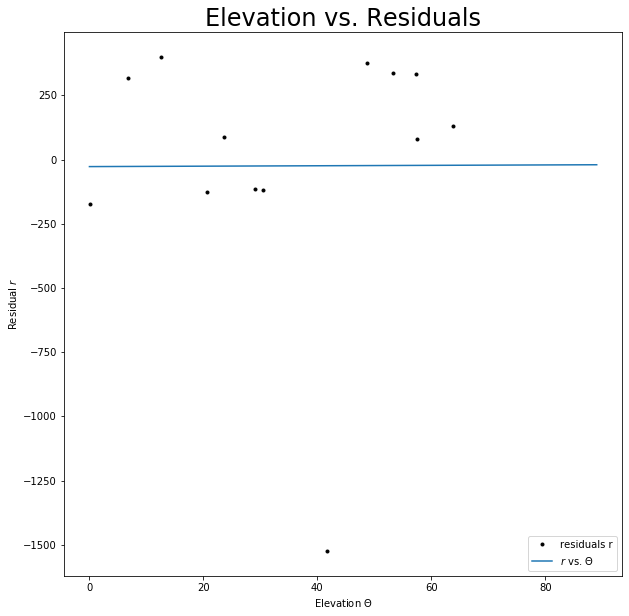

In [147]:
# 7.10 The A-Posteriori Variance Factor 𝜎̂2 and Using the Residuals

theta = np.vstack((error_gps[:,1:2],error_gln[:,1:2]))
model = np.polyfit(180*pi*theta.flatten(),r[-1].flatten(), 1)
predict = np.poly1d(model)

plt.figure(figsize=(10, 10))
plt.plot(180/pi*theta,r[-1],'.k',linewidth=2,label=u'residuals r')
plt.plot(range(0,90),predict(range(0,90)),label=u'$r$ vs. $\Theta$')
plt.title('Elevation vs. Residuals', fontsize = 24)
plt.ylabel('Residual $r$')
plt.xlabel('Elevation $\Theta$')
plt.legend(ncol=1, loc='lower right')    
plt.show()


## 7.11 Eliminating an Outlier

In GNSS applications **Receiver Autonomous Integrity Monitoring** (**RAIM**) is used to evaluate the position estimates. RAIM compares the residuals of a single epoch to determine whether all observed pseudo-ranges are consistent i.e., is the estimate precise. In our case we know that only one pseudo-range is inconsistent due to a blunder. However, it should be noted that due to the nature of the generation of random numbers more than one outlier can be present!

Since this a statistical approach to outlier detection the number of samples i.e., pseudo-ranges, must be significant enough to detect outliers. In typical positioning applications the number of degrees of freedom deemed acceptable is one, that is, we only need 5 observations... Fortunately GNSS observations have proven to be very robust.

Basically, RAIM algorithms make use of the measurements redundancy to check the relative consistency among them (by means of the residuals) and in case of detection, the most likely “failed” satellite is determined. Often the key assumption made in RAIM algorithms for civil aviation is that only one satellite may be faulty, i.e. the probability of multiple satellite failures is negligible. Another key issue related to RAIM algorithms is that one of their goals is to find measurement errors derived from non-nominal situations.

RAIM is not an industry standard, there are different methods of implementing it as long as the aim is to eliminate pseudo-ranges from the solution if they are suspected to represent an outlier using the residuals as a guide. Common approaches include:

    1) Iteratively eliminating satellites from the solution until no outliers are deemed present
    2) Creating solutions from all possible combinations of 4 satellites to identify satellites that lead to outliers
    
Although the 2nd method is more prevalent we will show an example below in which we potentially eliminate one satellite based on comparing its residual to the RMSE. Please note that the 2nd implementation of RAIM is essentially a robustness analysis i.e., how much influence does each satellite have on the final result. This is worthwhile knowing as it gives a direct indication of the spread of the positioning solutions given the observations - the same information may easily be gleaned from the first approach at a much lower computational cost.

___

Update the code cell below so that the maximum current estimated residual magnitude is held by the variable `max_r` i.e. you should take the absolute value of the residuals for this purpose! Also create a Boolean array `idx` so that all the elements corresponding to the elements in `r[-1` matching `max_r` are set to `True` and the rest to `False`. This vector now identifies the pseudo-ranges with the largest residuals and may be used for indexing arrays. The next step is to identify whether these residuals represent an outlier i.e., whether they deviate significantly from the root mean square of the residuals of the observations excluding the one with the largest residual. To achieve this create the variable `rmse` that holds the root mean square of the current residuals, but with the residual of the potential outlier eliminated. You may create the array of the current residuals with the potential outlier eliminated by using:

    r[-1][~idx]
    
The `~` operator is the logical *not* operator for Boolean values in Python. The result of the above code snippet returns an array of all the residuals for which the corresponding element in `idx` is set to `False`. The criterion that we will use for detecting an outlier is then whether the maximum residual is greater than 4 times the standard deviation of the residuals, not including the maximum residual. Update the `idx` vector for the locations of the absolute residuals exceeding the threshold by setting them to `True`.

The analysis is then exactly as before, other than that we eliminate the satellite from the process by setting its weight in the weight matrix `P` to zero i.e., by adding the statements:

    P[-1][bv_est,bv_est]=0
    dof = (n_svs-len(x_est[-1])-len(idx))
  
to the code and by updating the calculation of `var_fac` using the variable `dof` . This completely eliminates the satellites from all calculations



    var_fac_int = 1269.03
The solution has converged, this is a rare occurence when outliers are present

    var_fac[0] = 267.274
    x_est[0] = 
      37572.327
   -5513234.862
    3195349.181
          0.000

    var_fac[1] = 1269.027
    x_est[1] = 
      36916.950
   -5514040.665
    3194170.836
          0.000

    var_fac[2] = 267.273
    x_est[2] = 
      36916.951
   -5514040.693
    3194170.851
          0.000


    x_est[2] - xyz = 
         -5.932
        -27.238
          5.147


The DOPs with blunder
PDOP = 1.0
HDOP = 0.7
VDOP = 0.7
TDOP = 0.0


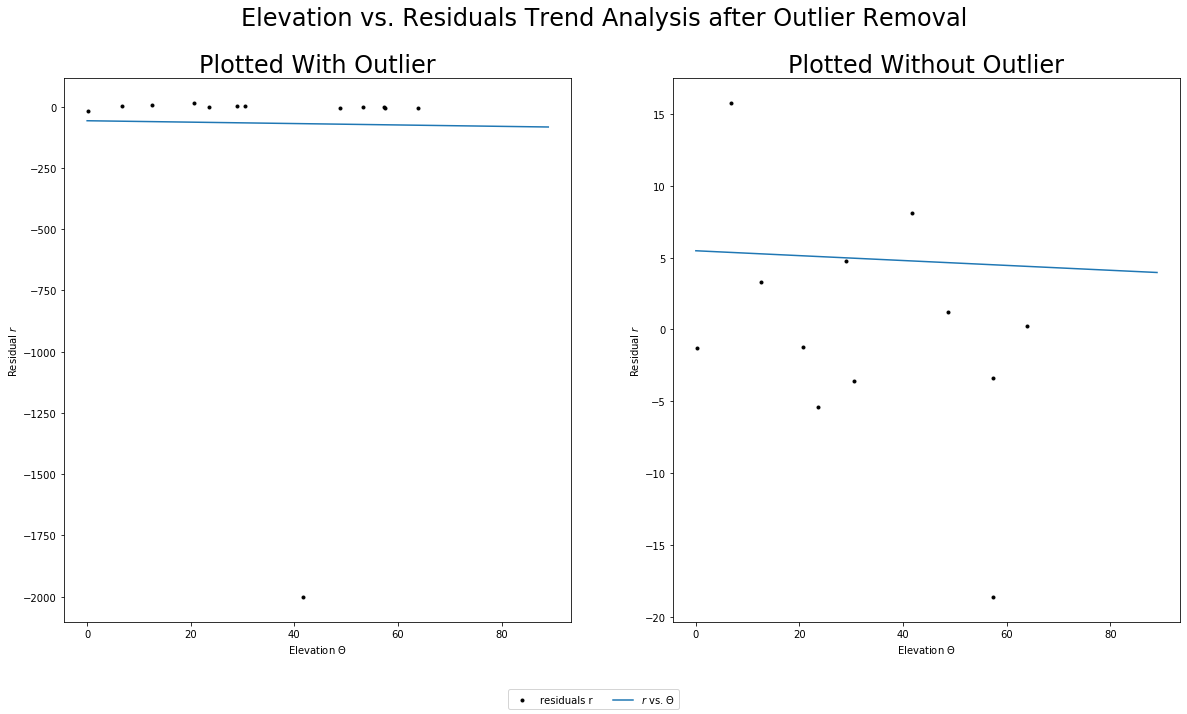

DOPS without blunder
PDOP = 1.1
HDOP = 0.8
VDOP = 0.7
TDOP = 0.0


In [337]:
## # Copy the code from 7.9 here and uncomment the code for step 7.11

    # Create an array of the elevation angles of the satellites

    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols = 2, sharey=False, sharex=True,figsize=(20, 10))

    theta = np.vstack((error_gps[:,1:2],error_gln[:,1:2]))
    model = np.polyfit(180*pi*theta[idx].flatten(),r[-1][idx].flatten(), 1)
    predict = np.poly1d(model)

    fig.suptitle('Elevation vs. Residuals Trend Analysis after Outlier Removal', fontsize = 24)
    
    theta = np.vstack((error_gps[:,1:2],error_gln[:,1:2]))
    model = np.polyfit(180*pi*theta.flatten(),r[-1].flatten(), 1)
    predict = np.poly1d(model)

    ax0.plot(180/pi*theta,r[-1],'.k',linewidth=2)
    ax0.plot(range(0,90),predict(range(0,90)))
    ax0.set_title('Plotted With Outlier', fontsize = 24)
    ax0.set_ylabel('Residual $r$')
    ax0.set_xlabel('Elevation $\Theta$')
    
    idx = np.ones(len(r[-1]))
    for sv in bv_est:
        idx[sv] = 0
    idx = idx > 0

    theta = np.vstack((error_gln[:,1:2],error_gps[:,1:2]))
    model = np.polyfit(180*pi*theta[idx].flatten(),r[-1][idx].flatten(), 1)
    predict = np.poly1d(model)
    
    ax1.plot(180/pi*theta[idx],r[-1][idx],'.k',linewidth=2,label=u'residuals r')
    ax1.plot(range(0,90),predict(range(0,90)),label=u'$r$ vs. $\Theta$')
    ax1.set_title('Plotted Without Outlier', fontsize = 24)
    ax1.set_ylabel('Residual $r$')
    ax1.set_xlabel('Elevation $\Theta$')
    fig.legend(ncol=2, loc='lower center')    
    plt.show()

    A[-1]=A[-1][idx,:]
    dop = np.diag(inv(A[-1].T@A[-1]))

    print('DOPS without blunder')
    print('PDOP = %.1f'%sqrt(sum(dop[0:3]**2)))
    print('HDOP = %.1f'%sqrt(sum(dop[0:2]**2)))
    print('VDOP = %.1f'%sqrt(dop[2]**2))
    print('TDOP = %.1f'%sqrt(dop[3]**2))

Worked Example:

    var_fac_int = 1269.03
    The solution has converged, this is a rare occurence when outliers are present

        var_fac[0] = 267.274
        x_est[0] = 
          37572.327
       -5513234.862
        3195349.181
              0.000

        var_fac[1] = 1269.027
        x_est[1] = 
          36916.950
       -5514040.665
        3194170.836
              0.000

        var_fac[2] = 267.273
        x_est[2] = 
          36916.951
       -5514040.693
        3194170.851
              0.000


        x_est[2] - xyz = 
             -4.407
            -31.084
              5.426


    The DOPs with blunder
    PDOP = 1.0
    HDOP = 0.7
    VDOP = 0.7
    TDOP = 0.0

    DOPS without blunder
    PDOP = 2.7
    HDOP = 2.6
    VDOP = 0.8
    TDOP = 0.0

